# Plot results of F-layer models

Our selection of models of the F-layer are executed via a command line program 
writing detailed output to files (one per model) and summary data to a CSV file.
This notebook generates the figures associated with these models.

In [1]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

import adjustText

import flayer
import feo_thermodynamics as feot
import earth_model
import layer_setup
import bulk_case_runner


In [2]:
def plot_summary_figure(results_df, target_latent_heat=None, target_density_excess=None, 
                        fig=None, ax=None, marker_x=None,
                        marker_t=None, marker=None, marker_color=None):
    """
    Create a plot showing the heat production as a function of layer setup
    
    The layer setup here amounts to two parameters, dx, the composition 
    difference from well mixed at the ICB and dt, the temperature
    difference from an adiabat at the ICB. We filter (and show) models
    that are not viabale on the basis of being too hot (above the
    liquidus at the ICB), too cold (below the temperature at the top
    of the F-layer at the ICB), or not statified (imaginary N_BV).
    
    Adding target_latent_heat (in W) or target_density_excess (in kg/m^3)
    plots lines on top showing 'viable' solutions - where they cross is
    the 'Earth like' solution.
    """
    if (fig is None) != (ax is None):
        raise ValueError("Must specify both fig and ax or have them both created.")
    if (fig is None) and (ax is None):
        fig, ax = plt.subplots(figsize=(7,6))
            
    if (marker_t is None) != (marker is None) != (marker_x is None) != (marker_color is None):
        raise ValueError("Must none or four marker parameters.")
    
    light_blue = '#91bfdb'
    point_scale = 400
    
    # Filter inputd data...
    # snow_df is only the cases where we ran a snow calc
    snow_df = results_df[~results_df["total_latent_heat"].isna()]
    # unstable_df is all the cases where the liquid is not stratified
    unstable_df = results_df[results_df["N2"] < 0.0]
    # Wrong dtdr is too cold (colder at the bottom than the top)
    wrong_dtdr_df = results_df[results_df["dT_cond"] < 0.0]
    # melting_df is above liquidus at ICB
    melting_df = results_df[results_df["dT_liq"] < 0.0]
     
    ax.axhline(c='k', lw=0.5, zorder=0)
    ax.axvline(c='k', lw=0.5, zorder=0)
    ax.scatter(unstable_df["dx"], unstable_df["dt"], s=40, facecolors='none', edgecolors='k')
    ax.scatter(wrong_dtdr_df["dx"], wrong_dtdr_df["dt"], s=15, facecolors='none', edgecolors='b')
    ax.scatter(melting_df["dx"], melting_df["dt"], s=15, facecolors='none', edgecolors='r')
    c = ax.scatter(snow_df["dx"], snow_df["dt"], c=np.array(snow_df["total_latent_heat"])/1.0E12,
                  norm=colors.Normalize(vmin=0.0, vmax=34), cmap='viridis',
                  s=snow_df["max_particle_radius"]*point_scale)  
    ax.set_ylabel("$\Delta T_{ICB}$")
    ax.set_xlabel("$\Delta X_{ICB}$")

    ax.set_xlim(-0.003, 0.0155)
    ax.set_ylim(-80, 105)
    fig.colorbar(c, label='Latent heat from snow (TW)', extend='max', location='right',
                 shrink=0.5, anchor=(0.0,0.9))
    
    # Size scale
    ax.scatter(0.0165, -20, s=0.001*point_scale, c='k', clip_on=False)
    ax.text(0.0175, -20, "1 mm")
    ax.scatter(0.0165, -30, s=0.01*point_scale, c='k', clip_on=False)
    ax.text(0.0175, -30, "1 cm")
    ax.scatter(0.0165, -40, s=0.1*point_scale, c='k', clip_on=False)
    ax.text(0.0175, -40, "10 cm")
    ax.scatter(0.0165, -50, s=1.0*point_scale, c='k', clip_on=False)
    ax.text(0.0175, -50, "1 m")
    
    # Why do the squares need to be offset?
    if marker is not None:
        ax.plot(marker_x, marker_t, marker=marker, markerfacecolor='none',
                markeredgecolor=marker_color, ms=np.sqrt(0.15*point_scale))
   
    
    if target_latent_heat is not None:
        heat_line_dt, heat_line_dx = get_dt_dx_latent_heat(results_df, target_latent_heat)
        ax.plot(heat_line_dx, heat_line_dt, 'r:', zorder=-1)
        
    if target_density_excess is not None:
        density_line_dt, density_line_dx = get_dt_dx_excess_density(results_df, target_density_excess)
        ax.plot(density_line_dx, density_line_dt, 'k:', zorder=-1)
        
        
    plt.show()
    
def get_dt_dx_both(df, target_latent_heat, target_density_excess):
    
    results = []
    errors = []
    
    heat_line_dt, heat_line_dx = get_dt_dx_latent_heat(df, target_latent_heat)
    density_line_dt, density_line_dx = get_dt_dx_excess_density(df, target_density_excess)
    
    for lx, lt in zip(heat_line_dx, heat_line_dt):
        for rhox, rhot in zip(density_line_dx, density_line_dt):
                if lx == rhox and lt == rhot:
                    rx = lx
                    rt = lt
                    
    return rx, rt
                    
    
def get_dt_dx_latent_heat(df, target_latent_heat):
    df["dlat_abs"] = abs((df.total_latent_heat.fillna(0)) - target_latent_heat)
    heat_line_dt = []
    heat_line_dx = []
    for this_dx in df.dx.unique():
        this_dx_df = df[df.dx == this_dx]
        # Skip the places where we didn't run any
        if this_dx_df.dlat_abs.min() < target_latent_heat:
            heat_line_dt.append(float(this_dx_df[this_dx_df.dlat_abs == this_dx_df.dlat_abs.min()].dt))
            heat_line_dx.append(this_dx)
    return heat_line_dt, heat_line_dx

def get_dt_dx_excess_density(df, target_density_excess):
    df["drho_abs"] = abs((df.liquid_density_excess + df.max_solid_excess_density.fillna(0)) 
                         - target_density_excess)
    density_line_dt = []
    density_line_dx = []
    for this_dt in summary_df_hetro.dt.unique():
        this_dt_df = summary_df_hetro[summary_df_hetro.dt == this_dt]
        density_line_dx.append(float(this_dt_df[this_dt_df.drho_abs == this_dt_df.drho_abs.min()].dx))
        density_line_dt.append(this_dt)
    return density_line_dt, density_line_dx

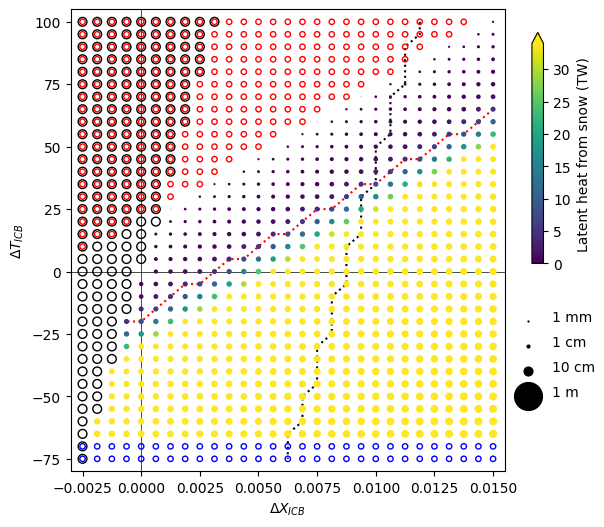

In [3]:
target_density_excess = 27.24 # This is prem - ak135f
target_latent_heat = 6.0*1.0E12 # W ... see arguments from Chris

summary_file = pathlib.Path('/Users/andreww/Code/slurry_cases/tx_grid/grid.csv')
summary_df_hetro = pd.read_csv(summary_file)
plot_summary_figure(summary_df_hetro, target_latent_heat=target_latent_heat, 
                    target_density_excess=target_density_excess)

In [4]:
import scipy as sp

def plot_valid_locus(results_df, fig=None, ax=None):
    """
    Create a plot showing the locus of 'valid' results
    
    """
    if (fig is None) != (ax is None):
        raise ValueError("Must specify both fig and ax or have them both created.")
    if (fig is None) and (ax is None):
        fig, ax = plt.subplots(figsize=(7,6))

    
    
    #snow_df = results_df[~results_df["total_latent_heat"].isna()]
    #valid_df = snow_df[snow_df["total_latent_heat"]/1.0E12 < 34.0]
    
    plot_df = results_df.copy(deep=True)
    plot_df['valid'] = np.where(plot_df["total_latent_heat"]/1.0E12 < 34.0, 10.0, 0.0)
    
    ax.axhline(c='k', lw=0.5, zorder=0)
    ax.axvline(c='k', lw=0.5, zorder=0)
    #ax.scatter(plot_df["dx"], plot_df["dt"], c=plot_df['valid'])

    ax.tricontour(plot_df["dx"], plot_df["dt"], plot_df['valid'], levels=[1.0])
    plt.show()
    
    # Interpolate onto regular grid
    grid_x, grid_y = np.mgrid[-0.002:0.014:200j, -60:100:200j]
    grid_z = sp.interpolate.griddata((plot_df["dx"], plot_df["dt"]), plot_df['valid'], 
                                     (grid_x, grid_y), method='nearest')
    
    # Gaussian filter to get rid of holes and smooth the edges
    grid_z = sp.ndimage.gaussian_filter(grid_z, 2.5)
    # Plot validity bounds (10 okay, 0 not okay)
    plt.contour(grid_x, grid_y, grid_z, levels=[1.0])
    


In [5]:
def plot_key_outputs(results_df, fig=None, ax=None):
    """
    Create a plot showing the locus of 'valid' results
    
    """
    if (fig is None) != (ax is None):
        raise ValueError("Must specify both fig and ax or have them both created.")
    if (fig is None) and (ax is None):
        fig, ax = plt.subplots(figsize=(7,6))
    
    
    #snow_df = results_df[~results_df["total_latent_heat"].isna()]
    #valid_df = snow_df[snow_df["total_latent_heat"]/1.0E12 < 34.0]
    
    plot_df = results_df.copy(deep=True)
    plot_df['valid'] = np.where(plot_df["total_latent_heat"]/1.0E12 < 34.0, 10.0, 0.0)
    
    ax.axhline(c='k', lw=0.5, zorder=0)
    ax.axvline(c='k', lw=0.5, zorder=0)
    #ax.scatter(plot_df["dx"], plot_df["dt"], c=plot_df['valid'])

    #ax.tricontour(plot_df["max_particle_radius"], plot_df["total_o_rate"], plot_df['valid'], levels=[1.0])
    plt.show()
    
    # Interpolate onto regular grid
    grid_x, grid_y = np.mgrid[0.0:plot_df["max_particle_radius"].max():200j, 0:plot_df["total_o_rate"].max():200j]
    grid_z = sp.interpolate.griddata((plot_df["max_particle_radius"].fillna(0), plot_df["total_o_rate"].fillna(0)), plot_df['valid'], 
                                     (grid_x, grid_y), method='nearest')
    
    # Gaussian filter to get rid of holes and smooth the edges
    grid_z = sp.ndimage.gaussian_filter(grid_z, 2.5)
    # Plot validity bounds (10 okay, 0 not okay)
    plt.contourf(grid_x, grid_y, grid_z, levels=[1.0, 2.0, 3.0, 10.0])
    



In [6]:
def plot_lines(data, fig=None, ax=None):
    """
    Function to plot lines in solid-fraction nuc rate space
    
    needs a list of data frames
    """
    if (fig is None) != (ax is None):
        raise ValueError("Must specify both fig and ax or have them both created.")
    if (fig is None) and (ax is None):
        fig, ax = plt.subplots(figsize=(7,6))
     
    point_scale = 400
        
    for item in data:
        df = item["df"]
        c = ax.scatter(df["max_nucleation_rate"], df["max_solid_volume_fraction"], 
                       c=np.array(df["total_latent_heat"])/1.0E12,
                       norm=colors.Normalize(vmin=0.0, vmax=34), cmap='viridis',
                       s=df["max_particle_radius"]*point_scale)
        
    
        ax.plot(df.iloc[0]["max_nucleation_rate"], df.iloc[0]["max_solid_volume_fraction"], 
                marker=item["m"], markerfacecolor='none', markeredgecolor=item["color"],
                ms=np.sqrt(0.15*point_scale))
        
        if 'ls' in item:
            ax.plot(df["max_nucleation_rate"], df["max_solid_volume_fraction"], 
                       linestyle=item['ls'], linewidth=0.5, color=item["color"])
        
    ax.set_ylabel("Solid fraction")
    ax.set_yscale("log")
    ax.set_xlabel("Nucleation rate (m$^{-3}$s$^{-1}$)")
    ax.set_xscale("log")

    ax.set_xlim(0.8E-15, 2.0E-4)
    ax.set_ylim(1.0E-17, 1.0E-2)
    fig.colorbar(c, label='Latent heat from snow (TW)', extend='max', location='right',
                 shrink=0.5, anchor=(0.0,0.9))
    
    # Size scale
    ax.scatter(0.8E-3, 1.0E-13, s=0.001*point_scale, c='k', clip_on=False)
    ax.text(2.0E-3, 1.0E-13, "1 mm")
    ax.scatter(0.8E-3, 1.0E-14, s=0.01*point_scale, c='k', clip_on=False)
    ax.text(2.0E-3, 1.0E-14, "1 cm")
    ax.scatter(0.8E-3, 1.0E-15, s=0.1*point_scale, c='k', clip_on=False)
    ax.text(2.0E-3, 1.0E-15, "10 cm")
    ax.scatter(0.8E-3, 1.0E-16, s=1.0*point_scale, c='k', clip_on=False)
    ax.text(2.0E-3, 1.0E-16, "1 m")
    
    # Why do the squares need to be offset?
    #ax.plot(0.009987, 40.1, marker='s', markerfacecolor='none', markeredgecolor='green', ms=np.sqrt(0.15*point_scale))
    #ax.plot(-0.000626, -24.8, marker='D', markerfacecolor='none', markeredgecolor='green', ms=np.sqrt(0.15*point_scale))
    
    plt.show()

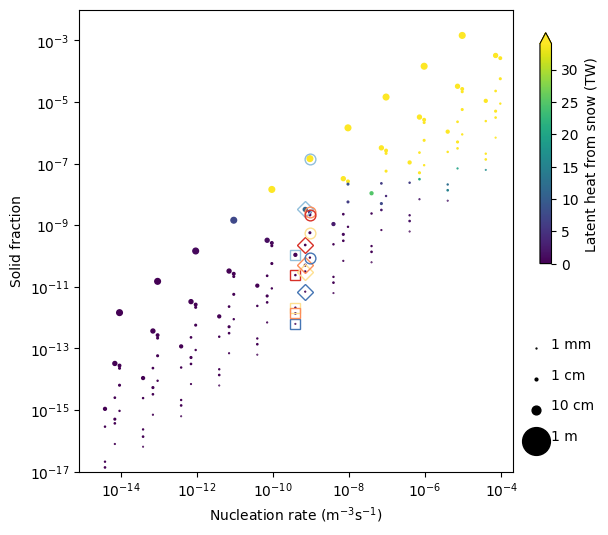

In [7]:
red = '#d73027'
orange = '#fc8d59'
yellow = '#fee090'
light_blue = '#91bfdb'
dark_blue = '#4575b4'

base_dir = '/Users/andreww/Code/slurry_cases'

data = [{'file': 'nuc_scan_1/yellow/scan.csv', 
         'color': yellow, 'm': 's'},
        {'file': 'nuc_scan_1/light_blue/scan.csv',
         'color': light_blue, 'm': 's'},
        {'file': 'nuc_scan_1/dark_blue/scan.csv',
         'color': dark_blue, 'm': 's'},
        {'file': 'nuc_scan_1/orange/scan.csv',
         'color': orange, 'm': 's'},
        {'file': 'nuc_scan_1/red/scan.csv',
         'color': red, 'm': 's'},
        {'file': 'nuc_scan_2/yellow/scan.csv',
         'color': yellow, 'm': 'D'},
        {'file': 'nuc_scan_2/light_blue/scan.csv',
         'color': light_blue, 'm': 'D'},
        {'file': 'nuc_scan_2/dark_blue/scan.csv',
         'color': dark_blue, 'm': 'D'},
        {'file': 'nuc_scan_2/orange/scan.csv',
         'color': orange, 'm': 'D'},
        {'file': 'nuc_scan_2/red/scan.csv',
         'color': red, 'm': 'D'},
       {'file': 'nuc_scan_3/yellow/scan.csv',
         'color': yellow, 'm': 'o'},
        {'file': 'nuc_scan_3/light_blue/scan.csv',
         'color': light_blue, 'm': 'o'},
        {'file': 'nuc_scan_3/dark_blue/scan.csv',
         'color': dark_blue, 'm': 'o'},
        {'file': 'nuc_scan_3/orange/scan.csv',
         'color': orange, 'm': 'o'},
        {'file': 'nuc_scan_3/red/scan.csv',
         'color': red, 'm': 'o'}]

for item in data:
    filep = pathlib.Path(base_dir)/item["file"]
    df = pd.read_csv(filep)
    item["df"] = df   
    
plot_lines(data)


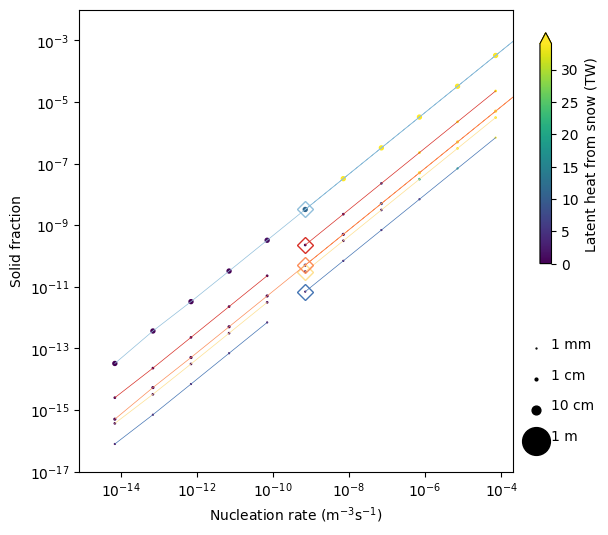

In [8]:
red = '#d73027'
orange = '#fc8d59'
yellow = '#fee090'
light_blue = '#91bfdb'
dark_blue = '#4575b4'

base_dir = '/Users/andreww/Code/slurry_cases'

data = [{'file': 'nuc_scan_2/yellow/scan.csv',
         'color': yellow, 'm': 'D', "ls": "-"},
        {'file': 'nuc_scan_2/light_blue/scan.csv',
         'color': light_blue, 'm': 'D', "ls": "-"},
        {'file': 'nuc_scan_2/dark_blue/scan.csv',
         'color': dark_blue, 'm': 'D', "ls": "-"},
        {'file': 'nuc_scan_2/orange/scan.csv',
         'color': orange, 'm': 'D', "ls": "-"},
        {'file': 'nuc_scan_2/red/scan.csv',
         'color': red, 'm': 'D', "ls": "-"}]

for item in data:
    filep = pathlib.Path(base_dir)/item["file"]
    df = pd.read_csv(filep)
    item["df"] = df   
    
plot_lines(data)

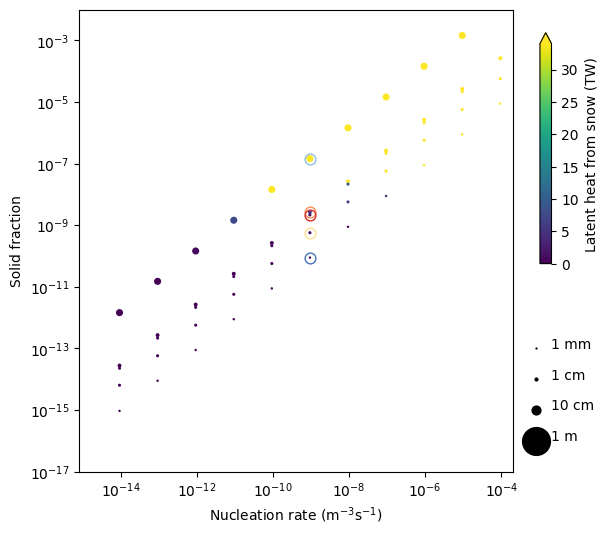

In [9]:
red = '#d73027'
orange = '#fc8d59'
yellow = '#fee090'
light_blue = '#91bfdb'
dark_blue = '#4575b4'

base_dir = '/Users/andreww/Code/slurry_cases'

data = [{'file': 'nuc_scan_3/yellow/scan.csv',
         'color': yellow, 'm': 'o'},
        {'file': 'nuc_scan_3/light_blue/scan.csv',
         'color': light_blue, 'm': 'o'},
        {'file': 'nuc_scan_3/dark_blue/scan.csv',
         'color': dark_blue, 'm': 'o'},
        {'file': 'nuc_scan_3/orange/scan.csv',
         'color': orange, 'm': 'o'},
        {'file': 'nuc_scan_3/red/scan.csv',
         'color': red, 'm': 'o'}]

for item in data:
    filep = pathlib.Path(base_dir)/item["file"]
    df = pd.read_csv(filep)
    item["df"] = df   
    
plot_lines(data)

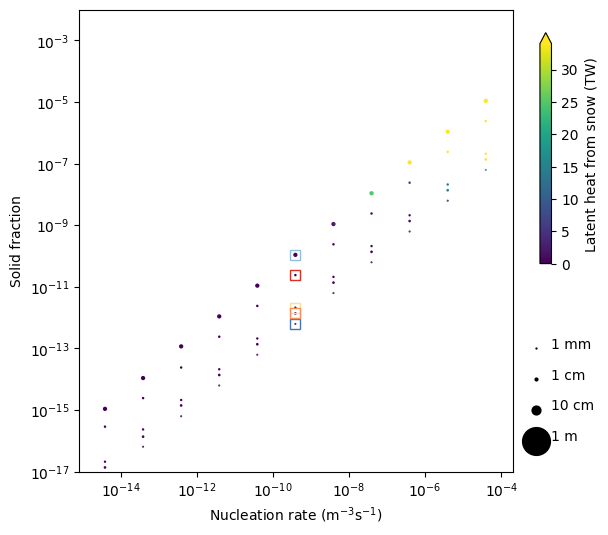

In [10]:
red = '#d73027'
orange = '#fc8d59'
yellow = '#fee090'
light_blue = '#91bfdb'
dark_blue = '#4575b4'

base_dir = '/Users/andreww/Code/slurry_cases'

data = [{'file': 'nuc_scan_1/yellow/scan.csv',
         'color': yellow, 'm': 's'},
        {'file': 'nuc_scan_1/light_blue/scan.csv',
         'color': light_blue, 'm': 's'},
        {'file': 'nuc_scan_1/dark_blue/scan.csv',
         'color': dark_blue, 'm': 's'},
        {'file': 'nuc_scan_1/orange/scan.csv',
         'color': orange, 'm': 's'},
        {'file': 'nuc_scan_1/red/scan.csv',
         'color': red, 'm': 's'}]

for item in data:
    filep = pathlib.Path(base_dir)/item["file"]
    df = pd.read_csv(filep)
    item["df"] = df   
    
plot_lines(data)

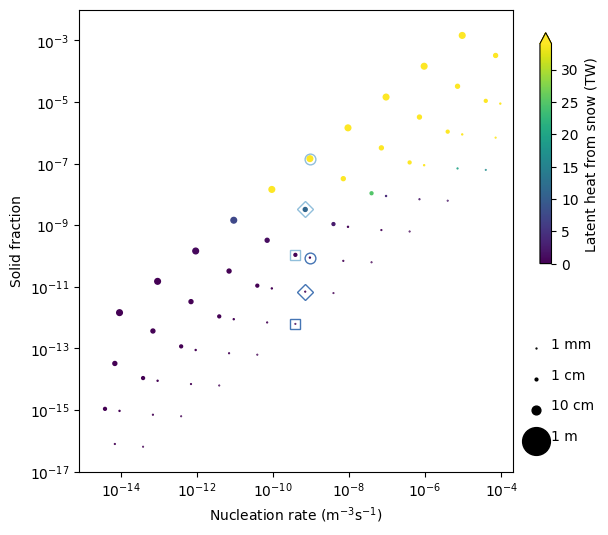

In [11]:
red = '#d73027'
orange = '#fc8d59'
yellow = '#fee090'
light_blue = '#91bfdb'
dark_blue = '#4575b4'

base_dir = '/Users/andreww/Code/slurry_cases'

data = [{'file': 'nuc_scan_1/light_blue/scan.csv',
         'color': light_blue, 'm': 's'},
        {'file': 'nuc_scan_2/light_blue/scan.csv',
         'color': light_blue, 'm': 'D'},
        {'file': 'nuc_scan_3/light_blue/scan.csv',
         'color': light_blue, 'm': 'o'},
        {'file': 'nuc_scan_1/dark_blue/scan.csv',
         'color': dark_blue, 'm': 's'},
        {'file': 'nuc_scan_2/dark_blue/scan.csv',
         'color': dark_blue, 'm': 'D'},
        {'file': 'nuc_scan_3/dark_blue/scan.csv',
         'color': dark_blue, 'm': 'o'}]

for item in data:
    filep = pathlib.Path(base_dir)/item["file"]
    df = pd.read_csv(filep)
    item["df"] = df   
    
plot_lines(data)

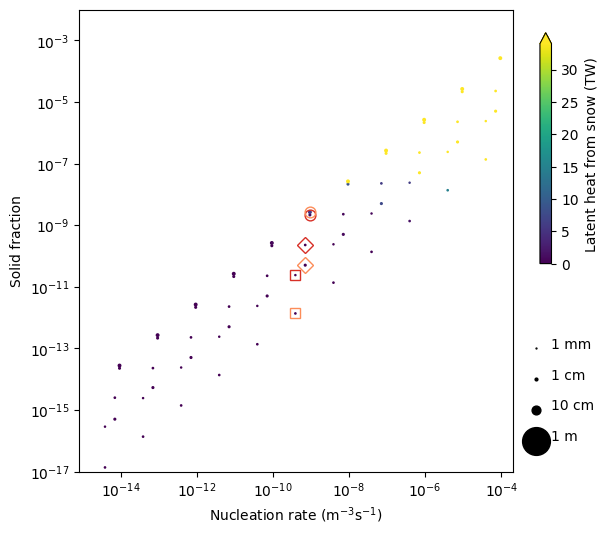

In [12]:
red = '#d73027'
orange = '#fc8d59'
yellow = '#fee090'
light_blue = '#91bfdb'
dark_blue = '#4575b4'

base_dir = '/Users/andreww/Code/slurry_cases'

data = [{'file': 'nuc_scan_1/red/scan.csv',
         'color': red, 'm': 's'},
        {'file': 'nuc_scan_2/red/scan.csv',
         'color': red, 'm': 'D'},
        {'file': 'nuc_scan_3/red/scan.csv',
         'color': red, 'm': 'o'},
        {'file': 'nuc_scan_1/orange/scan.csv',
         'color': orange, 'm': 's'},
        {'file': 'nuc_scan_2/orange/scan.csv',
         'color': orange, 'm': 'D'},
        {'file': 'nuc_scan_3/orange/scan.csv',
         'color': orange, 'm': 'o'}]

for item in data:
    filep = pathlib.Path(base_dir)/item["file"]
    df = pd.read_csv(filep)
    item["df"] = df   
    
plot_lines(data)

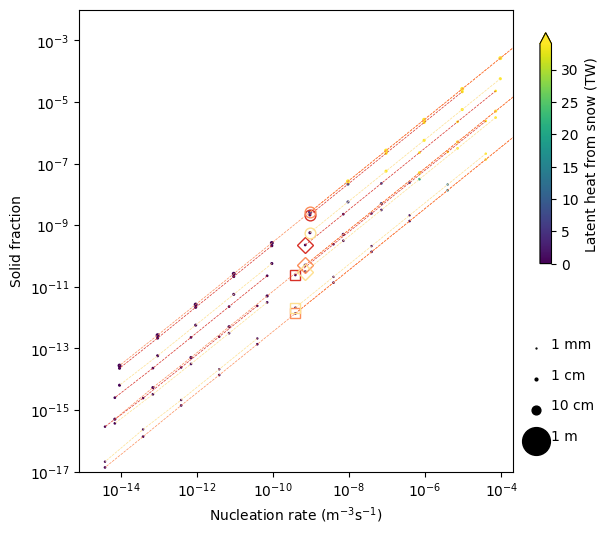

In [13]:
red = '#d73027'
orange = '#fc8d59'
yellow = '#fee090'
light_blue = '#91bfdb'
dark_blue = '#4575b4'

base_dir = '/Users/andreww/Code/slurry_cases'

data = [{'file': 'nuc_scan_1/red/scan.csv',
         'color': red, 'm': 's', "ls": "--"},
        {'file': 'nuc_scan_2/red/scan.csv',
         'color': red, 'm': 'D', "ls": "--"},
        {'file': 'nuc_scan_3/red/scan.csv',
         'color': red, 'm': 'o', "ls": "--"},
        {'file': 'nuc_scan_1/orange/scan.csv',
         'color': orange, 'm': 's', "ls": "--"},
        {'file': 'nuc_scan_2/orange/scan.csv',
         'color': orange, 'm': 'D', "ls": "--"},
        {'file': 'nuc_scan_3/orange/scan.csv',
         'color': orange, 'm': 'o', "ls": "--"},
        {'file': 'nuc_scan_1/yellow/scan.csv',
         'color': yellow, 'm': 's', "ls": "--"},
        {'file': 'nuc_scan_2/yellow/scan.csv',
         'color': yellow, 'm': 'D', "ls": "--"},
        {'file': 'nuc_scan_3/yellow/scan.csv',
         'color': yellow, 'm': 'o', "ls": "--"}]

for item in data:
    filep = pathlib.Path(base_dir)/item["file"]
    df = pd.read_csv(filep)
    item["df"] = df   
    
plot_lines(data)

tx_grid_nuc2_red
Best x: 0.00625 best T: -65.0
Latent heat: 0.01238537998926186 TW
Excess density: 26.278166164551294 kg m^-3
NOT OK


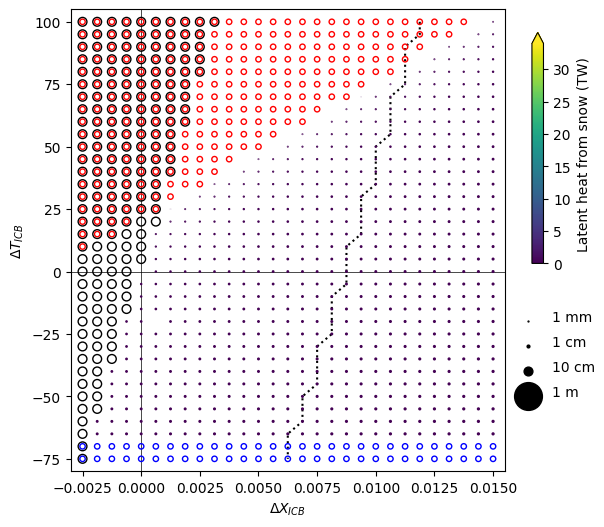

tx_grid_nuc1_red
Best x: 0.009375 best T: 30.0
Latent heat: 5.784362294745685 TW
Excess density: 26.625886396548594 kg m^-3
OK


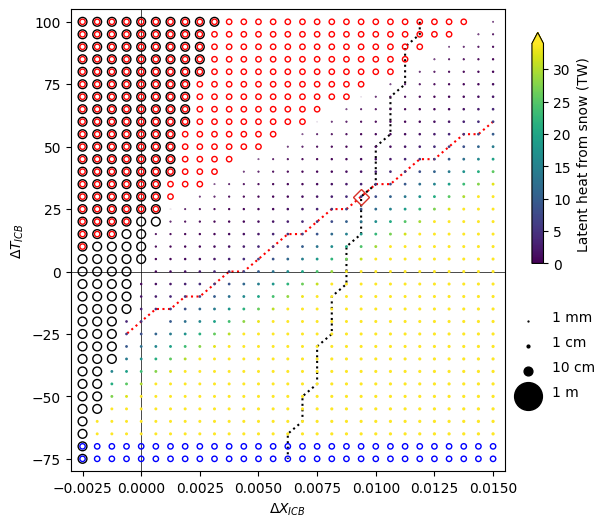

tx_grid_red
Best x: 0.00625 best T: -65.0
Latent heat: 1.236550350536626 TW
Excess density: 26.278168321099656 kg m^-3
OK


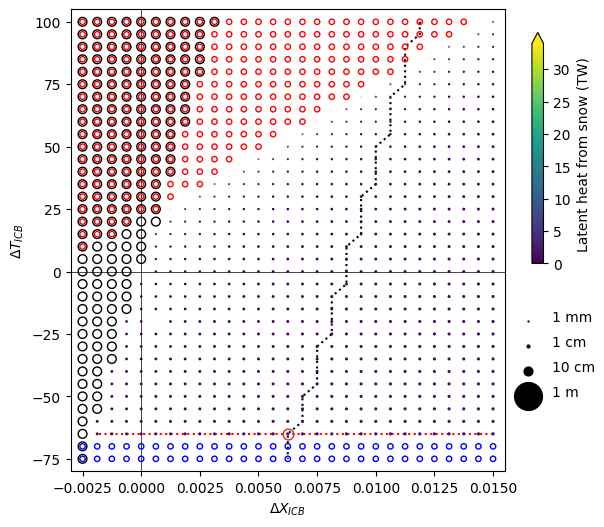

tx_grid_nuc2_orange
Best x: 0.00625 best T: -65.0
Latent heat: 0.09979901273785001 TW
Excess density: 26.27816617776989 kg m^-3
NOT OK


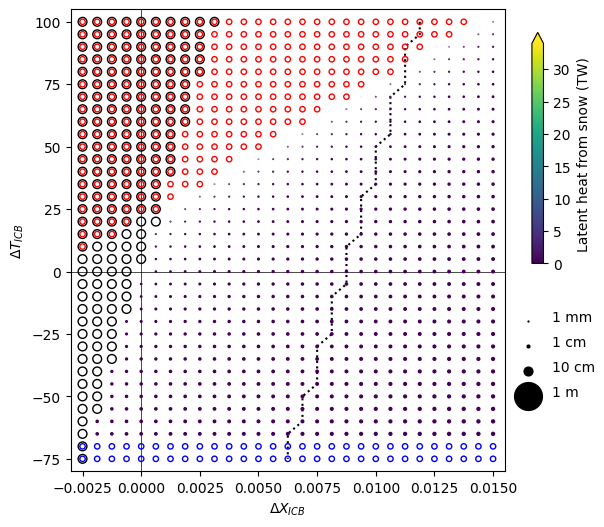

tx_grid_nuc1_orange
Best x: 0.009375 best T: 30.0
Latent heat: 6.784781787043857 TW
Excess density: 26.625872336589964 kg m^-3
OK


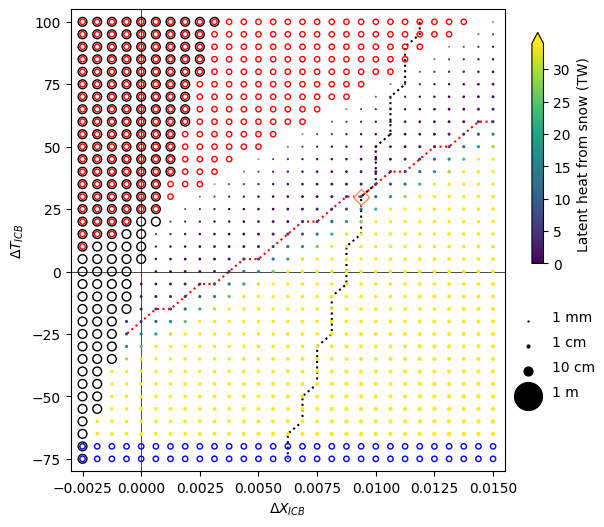

tx_grid_orange
Best x: 0.0075 best T: -40.0
Latent heat: 5.922056968286372 TW
Excess density: 27.726837370995778 kg m^-3
OK


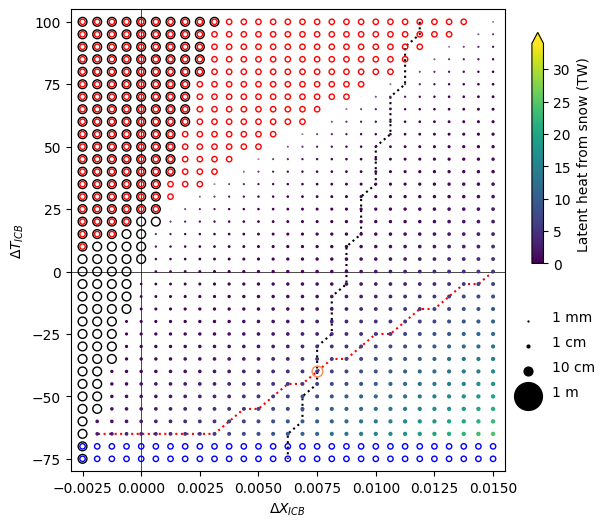

tx_grid_nuc2_yellow
Best x: 0.00625 best T: -65.0
Latent heat: 0.009363547133907394 TW
Excess density: 26.278166149264507 kg m^-3
NOT OK


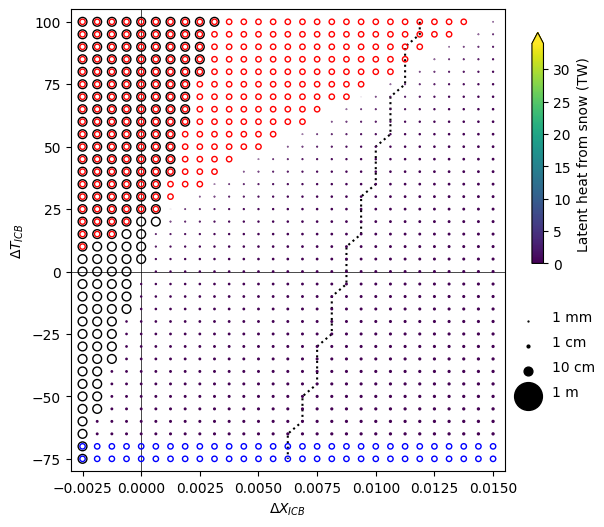

tx_grid_nuc1_yellow
Best x: 0.009375 best T: 20.0
Latent heat: 5.570528667117893 TW
Excess density: 27.634095737112148 kg m^-3
OK


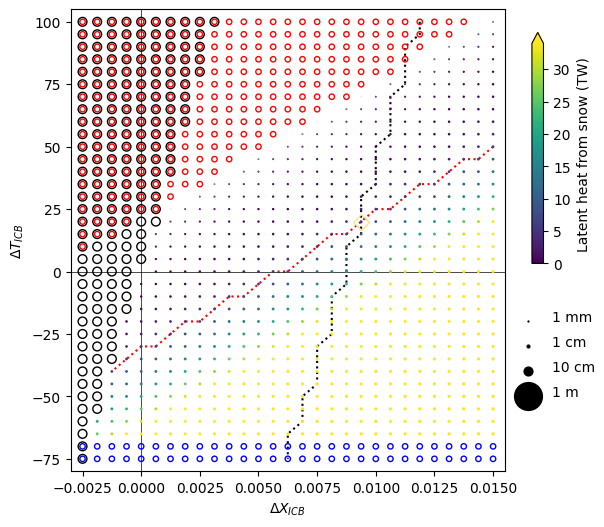

tx_grid_yellow
Best x: 0.00625 best T: -65.0
Latent heat: 0.9515824600100667 TW
Excess density: 26.278166792157208 kg m^-3
NOT OK


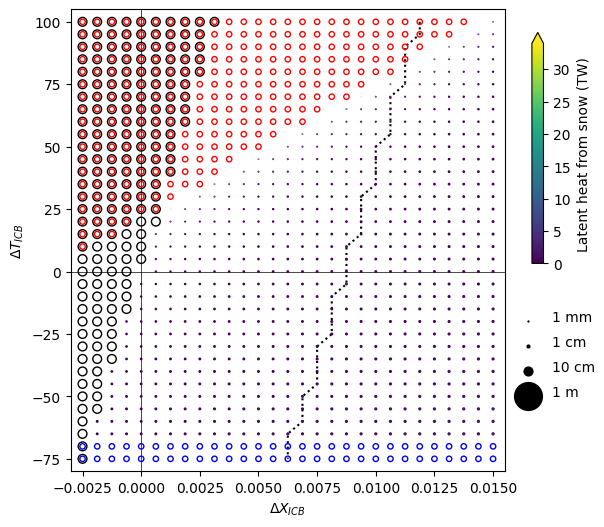

tx_grid_nuc2
Best x: 0.0075 best T: -35.0
Latent heat: 6.5258926723857 TW
Excess density: 27.223089238534158 kg m^-3
OK


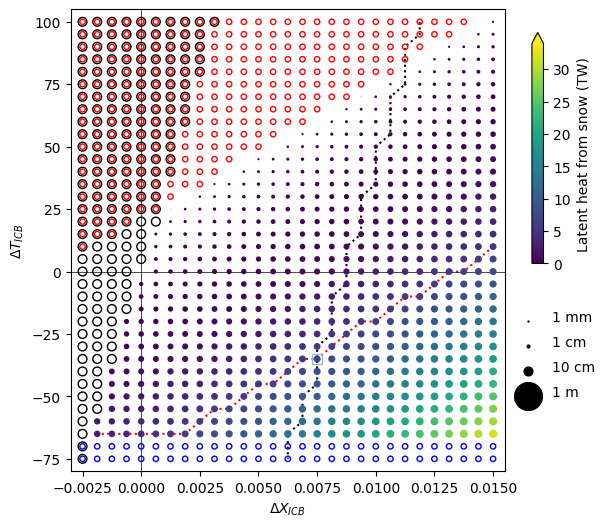

tx_grid_nuc1
Best x: 0.010625 best T: 60.0
Latent heat: 1.77026881932198 TW
Excess density: 27.572195463711978 kg m^-3
OK


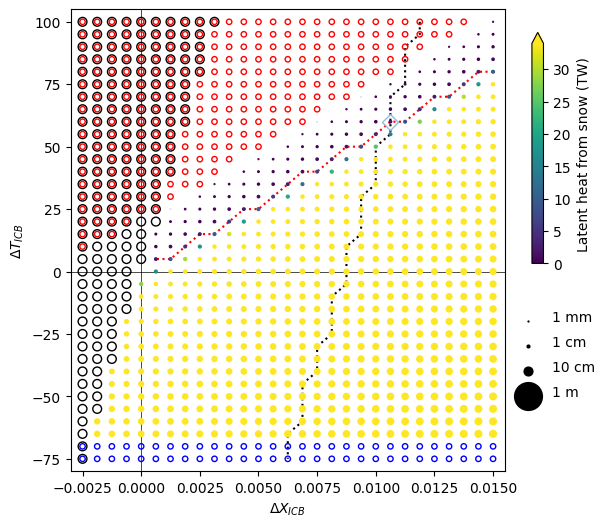

tx_grid
Best x: 0.01 best T: 35.0
Latent heat: 7.668878000005536 TW
Excess density: 28.107415024767764 kg m^-3
OK


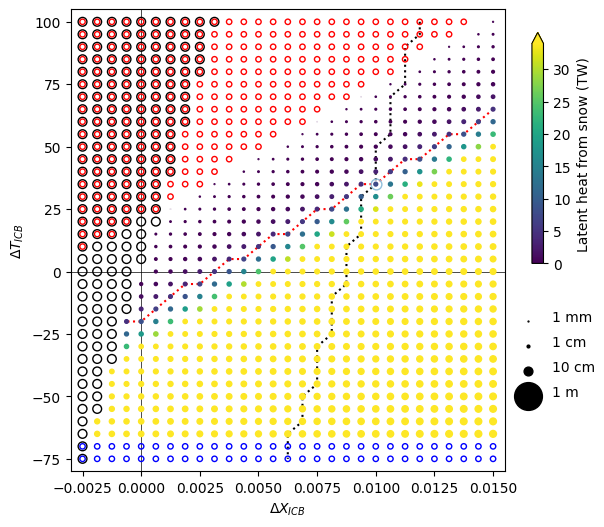

tx_grid_nuc2_dark_blue
Best x: 0.00625 best T: -65.0
Latent heat: 0.0005711992511607973 TW
Excess density: 26.27816614371659 kg m^-3
NOT OK


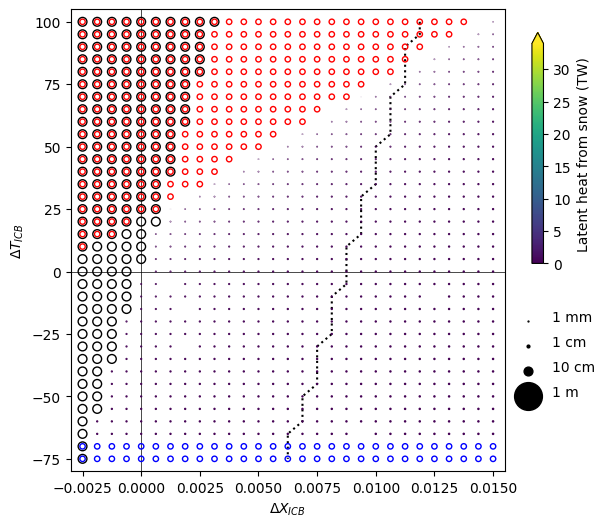

tx_grid_nuc1_dark_blue
Best x: 0.00625 best T: -65.0
Latent heat: 5.695396178676745 TW
Excess density: 26.27817561106349 kg m^-3
OK


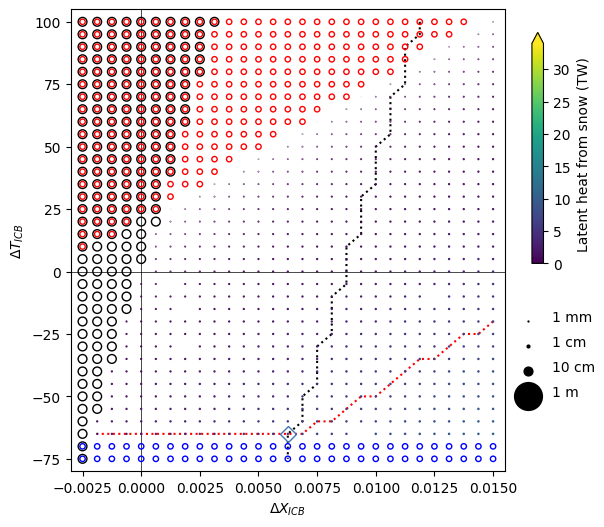

tx_grid_dark_blue
Best x: 0.00625 best T: -65.0
Latent heat: 0.056954215263577405 TW
Excess density: 26.278166237450932 kg m^-3
NOT OK


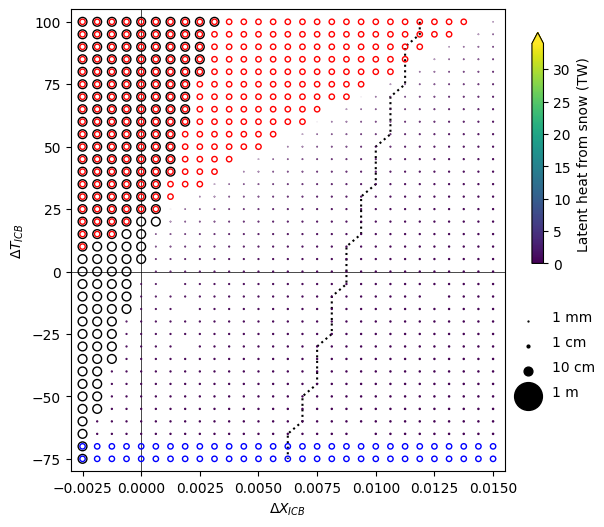

In [14]:
target_density_excess = 27.24 # This is prem - ak135f
target_latent_heat = 6.0*1.0E12 # W ... see arguments from Chris

basepath = pathlib.Path('/Users/andreww/Code/slurry_cases/')
filename = "grid.csv"

base_dir = '/Users/andreww/Code/slurry_cases'

red = '#d73027'
orange = '#fc8d59'
yellow = '#fee090'
light_blue = '#91bfdb'
dark_blue = '#4575b4'

# Dimond - high nuc rate
# Circle - med nuc rate
# square - low nuc rate

data = [{'dir': 'tx_grid_nuc2_red',
         'color': red, 'm': 's'},
        {'dir': 'tx_grid_nuc1_red',
         'color': red, 'm': 'D'},
        {'dir': 'tx_grid_red',
         'color': red, 'm': 'o'},
        {'dir': 'tx_grid_nuc2_orange',
         'color': orange, 'm': 's'},
        {'dir': 'tx_grid_nuc1_orange',
         'color': orange, 'm': 'D'},
        {'dir': 'tx_grid_orange',
         'color': orange, 'm': 'o'},
        {'dir': 'tx_grid_nuc2_yellow',
         'color': yellow, 'm': 's'},
        {'dir': 'tx_grid_nuc1_yellow',
         'color': yellow, 'm': 'D'},
        {'dir': 'tx_grid_yellow',
         'color': yellow, 'm': 'o'},
        {'dir': 'tx_grid_nuc2',
         'color': light_blue, 'm': 's'},
        {'dir': 'tx_grid_nuc1',
         'color': light_blue, 'm': 'D'},
        {'dir': 'tx_grid',
         'color': light_blue, 'm': 'o'},
        {'dir': 'tx_grid_nuc2_dark_blue',
         'color': dark_blue, 'm': 's'},
        {'dir': 'tx_grid_nuc1_dark_blue',
         'color': dark_blue, 'm': 'D'},
        {'dir': 'tx_grid_dark_blue',
         'color': dark_blue, 'm': 'o'}]

all_matches = None

for thisdata in data:
    print(thisdata["dir"])
    summary_file = basepath / thisdata["dir"] / filename
    summary_df_hetro = pd.read_csv(summary_file)
    
    lx, lt = get_dt_dx_both(summary_df_hetro, target_latent_heat=target_latent_heat, 
                            target_density_excess=target_density_excess)
    print("Best x:", lx, "best T:", lt)
    match = summary_df_hetro[(summary_df_hetro["dt"] == lt) & 
                             (summary_df_hetro["dx"] == lx)].copy()
    latent_heat = match["total_latent_heat"].values[0] / 1.0E12 # TW
    excess_density = match.liquid_density_excess.values[0] + \
        match.max_solid_excess_density.fillna(0).values[0]
    print(f"Latent heat: {latent_heat} TW")
    print(f"Excess density: {excess_density} kg m^-3")
    if ((abs(excess_density - target_density_excess) < 2.0) and 
        (abs(latent_heat - target_latent_heat) < 6.0E12) and
        (latent_heat > 1.0)):
        print("OK")
        match["color"] = thisdata["color"]
        match["marker"] = thisdata["m"]
        full_file = basepath / thisdata["dir"] / f"detailed_output/case_{lt}_{lx}.pkl"
        match["full_file"] = str(full_file)
        if all_matches is None:
            all_matches = match
        else:
            all_matches = all_matches.append(match)
            
        plot_summary_figure(summary_df_hetro, target_latent_heat=target_latent_heat, 
                        target_density_excess=target_density_excess, marker_x=lx,
                        marker_t=lt, marker=thisdata["m"], marker_color=thisdata["color"])
            
    else:
        print("NOT OK")  
        plot_summary_figure(summary_df_hetro, target_density_excess=target_density_excess)
    

In [15]:
all_matches

,case,dt,dx,N2,dT_liq,dT_cond,liquid_density_excess,total_latent_heat,total_o_rate,max_particle_radius,max_solid_volume_fraction,max_nucleation_rate,max_solid_excess_density,dlat_abs,drho_abs,color,marker,full_file
415,case_30.0_0.009375,30.0,0.009375,4.923055e-08,42.747943,98.157535,26.625869,5.784362e+12,339734.584928,0.002255,2.236752e-08,7.015777e-08,1.772807e-05,2.156377e+11,0.614114,#d73027,D,/Users/andreww/Code/slurry_cases/tx_grid_nuc1_...
971,case_-65.0_0.00625,-65.0,0.006250,4.858844e-08,120.549868,3.157535,26.278166,1.236550e+12,74151.848430,0.003920,2.709862e-09,9.560383e-10,2.178331e-06,4.763450e+12,0.961832,#d73027,o,/Users/andreww/Code/slurry_cases/tx_grid_red/d...
415,case_30.0_0.009375,30.0,0.009375,4.923055e-08,42.747943,98.157535,26.625869,6.784782e+12,398233.403916,0.003819,4.628062e-09,7.015777e-08,3.668114e-06,7.847818e+11,0.614128,#fc8d59,D,/Users/andreww/Code/slurry_cases/tx_grid_nuc1_...
824,case_-40.0_0.0075,-40.0,0.007500,5.126271e-08,102.422297,28.157535,27.726835,5.922057e+12,351961.051837,0.008335,2.744945e-09,9.397019e-10,2.194662e-06,7.794303e+10,0.486837,#fc8d59,o,/Users/andreww/Code/slurry_cases/tx_grid_orang...
473,case_20.0_0.009375,20.0,0.009375,5.109166e-08,52.747943,88.157535,27.634090,5.570529e+12,327289.372377,0.002398,7.718415e-09,7.920294e-08,6.118558e-06,4.294713e+11,0.394096,#fee090,D,/Users/andreww/Code/slurry_cases/tx_grid_nuc1_...
795,case_-35.0_0.0075,-35.0,0.007500,5.033287e-08,97.422297,33.157535,27.223088,6.525893e+12,387845.566986,0.040586,1.289582e-09,9.336226e-12,1.030967e-06,5.258927e+11,0.016911,#91bfdb,s,/Users/andreww/Code/slurry_cases/tx_grid_nuc2/...
239,case_60.0_0.010625,60.0,0.010625,5.097750e-08,19.643101,128.157535,27.572195,1.770269e+12,103076.584948,0.007646,8.937046e-10,1.872808e-08,7.044073e-07,4.229731e+12,0.332195,#91bfdb,D,/Users/andreww/Code/slurry_cases/tx_grid_nuc1/...
385,case_35.0_0.01,35.0,0.010000,5.196536e-08,41.194379,103.157535,28.107413,7.668878e+12,448454.208916,0.018890,2.385875e-09,6.825720e-10,1.886092e-06,1.668878e+12,0.867415,#91bfdb,o,/Users/andreww/Code/slurry_cases/tx_grid/detai...
971,case_-65.0_0.00625,-65.0,0.006250,4.858844e-08,120.549868,3.157535,26.278166,5.695396e+12,341340.897601,0.001507,1.177865e-08,9.560383e-08,9.468295e-06,3.046038e+11,0.961824,#4575b4,D,/Users/andreww/Code/slurry_cases/tx_grid_nuc1_...


In [36]:
def plot_matches(matches_df, fig=None, ax=None):
    """
    Create a summary plot.
    """
    if (fig is None) != (ax is None):
        raise ValueError("Must specify both fig and ax or have them both created.")
    if (fig is None) and (ax is None):
        fig, ax = plt.subplots(figsize=(7,6))
 
    point_scale = 100
    
     
    ax.axhline(c='k', lw=0.5, zorder=0)
    ax.axvline(c='k', lw=0.5, zorder=0)
    ax.set_xlim(-0.003, 0.0155)
    ax.set_ylim(-80, 105)

    for index, row in matches_df.iterrows():
        # We need to reach into the full output for some info... grrr
        full_data = bulk_case_runner.load_case_data(row["full_file"])
        
        ax.plot(row.dx, row["dt"], marker=row.marker, markerfacecolor='none',
                markeredgecolor=row.color, ms=np.sqrt(full_data["growth_rate"]*point_scale))
        
    ax.set_ylabel("$\Delta T_{ICB}$")
    ax.set_xlabel("$\Delta X_{ICB}$")

    ax1 = inset_axes(ax, width="40%", height="60%", loc=2, borderpad=1)
    ax1.set_yscale('log')
    #ax1.xaxis.set_label_position('top')
    ax1.yaxis.set_label_position('right') 
    ax1.yaxis.tick_right()
    #ax1.xaxis.tick_top()
    ax1.set_ylabel("Max nucleation rate (m$^{-3}$s$^{-1}$)")
    ax1.set_xlabel("Maximum particle radius (m)")
    point_scale = 100
    
    texts = []
    for index, row in matches_df.iterrows():
        
        # We need to reach into the full output for some info... grrr
        full_data = bulk_case_runner.load_case_data(row["full_file"])        
        ax1.plot(row["max_particle_radius"], row["max_nucleation_rate"], marker=row.marker, markerfacecolor='none',
                markeredgecolor=row.color)#, ms=np.sqrt(full_data["growth_rate"]*point_scale))
        
        t = ax1.annotate(f"{full_data['growth_rate']:.1f}", (row["max_particle_radius"], row["max_nucleation_rate"]),
                        color=row.color)
        texts.append(t)
        
    adjustText.adjust_text(texts)


    
    plt.show()
    

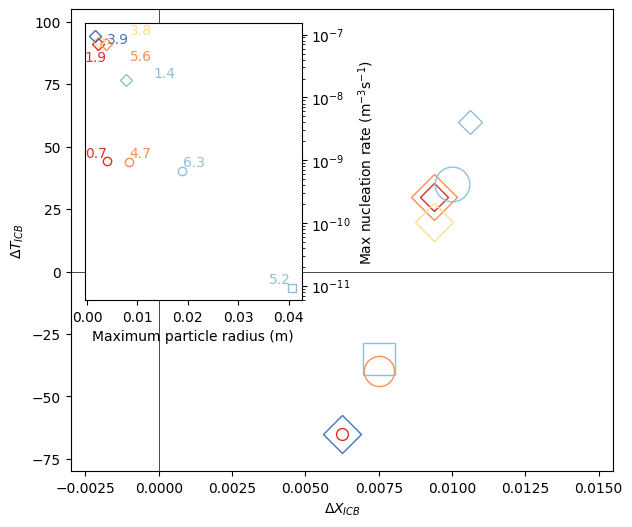

In [37]:
plot_matches(all_matches)